# 02 · S3WD v02 主线：参考元组 + 相似度 + 漂移闭环

本 Notebook 演示 S3WD v02 流程：利用 Reference Tuple（参考元组）/混合相似度/批级阈值小网格，结合漂移分级响应（S1/S2/S3）。
运行前请确认 `configs/s3wd_airline_v02.yaml` 已更新至 v02 键位，并准备好 Airlines 数据。


In [1]:
import os
from pathlib import Path
import sys
import json
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / 's3wdlib').exists() and (PROJECT_ROOT.parent / 's3wdlib').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')

print("【步骤0】环境信息：", {
    'python': sys.version.split()[0],
    'cwd': os.getcwd(),
    'project_root': str(PROJECT_ROOT)
})



【步骤0】环境信息： {'python': '3.11.5', 'cwd': 'e:\\yan\\组\\三支决策\\机器学习\\C三支决策与不平衡数据集分类\\S3WD实验\\notebooks', 'project_root': 'e:\\yan\\组\\三支决策\\机器学习\\C三支决策与不平衡数据集分类\\S3WD实验'}


In [2]:
from s3wdlib.config_loader import load_yaml_cfg, extract_vars, show_cfg
from s3wdlib import (
    augment_airline_features,
    assign_year_from_month_sequence,
    run_streaming_flow,
    assign_buckets,
    build_ref_tuples,
    combine_history,
    corr_to_set,
    to_trisect_probs,
    expected_cost,
    expected_fbeta,
    select_alpha_beta,
    ema_clip,
    detect_drift,
    apply_actions,
    compute_region_masks,
)
import s3wdlib.bucketizer as bucketizer
import s3wdlib.similarity as similarity
import s3wdlib.drift_controller as drift_controller
from s3wdlib.gwb import GWBProbEstimator

CONFIG_PATH = Path('../configs/s3wd_airline_v02.yaml')
cfg = load_yaml_cfg(str(CONFIG_PATH))
show_cfg(cfg)
vars_flat = extract_vars(cfg)

bucketizer.configure(cfg.get('BUCKET'))
similarity.configure(cfg.get('SIMILARITY'))

sim_cfg = similarity.current_config()
drift_thresholds = {
    'psi_thresholds': cfg['DRIFT'].get('psi_thresholds'),
    'tv_thresholds': cfg['DRIFT'].get('tv_thresholds'),
    'posrate_shift': cfg['DRIFT'].get('posrate_shift'),
    'perf_drop': cfg['DRIFT'].get('perf_drop'),
    'debounce_windows': cfg['DRIFT'].get('debounce_windows', 1),
}
actions_cfg = cfg['DRIFT'].get('actions', {})


[INFO] Loading faiss.
[INFO] Successfully loaded faiss.


【配置快照】
- DATA: {'data_dir': '../data', 'data_file': 'airlines_train_regression_1000000.arff', 'continuous_label': 'DepDelay', 'threshold': 15, 'threshold_op': '>', 'test_size': 0.3, 'val_size': 0.3, 'random_state': 42, 'start_year': 1987}
- LEVEL: {'level_pcts': [0.6, 0.8, 1.0], 'ranker': 'mi'}
- KWB: {'k': 6, 'metric': 'euclidean', 'eps': 1e-06, 'use_faiss': True, 'faiss_gpu': True}
- GWB: {'k': 10, 'metric': 'euclidean', 'eps': 1e-06, 'mode': 'epanechnikov', 'bandwidth': 0.72, 'bandwidth_scale': 1.05, 'use_faiss': True, 'faiss_gpu': True, 'categorical_features': ['Origin', 'Dest'], 'category_penalty': 0.3}
- S3WD: {'c1': 0.37, 'c2': 0.63, 'xi_min': 0.1, 'theta_pos': 0.9, 'theta_neg': 0.1, 'sigma': 3.0, 'regret_mode': 'utility', 'penalty_large': 1000000.0, 'gamma_last': True, 'gap': 0.02}
- PSO: {'particles': 20, 'iters': 20, 'w_max': 0.9, 'w_min': 0.4, 'c1': 2.8, 'c2': 1.3, 'seed': 42, 'use_gpu': True}
- BUCKET: {'keys': ['Origin', 'dep_block'], 'min_bucket': 50, 'backoff': ['Origin'

In [3]:
# 利用封装的 run_streaming_flow 前滚整个 v02 流程
flow_results = run_streaming_flow(str(CONFIG_PATH))
flow_threshold_df = flow_results['threshold_trace']
flow_metrics_df = flow_results['window_metrics']
flow_drift_df = flow_results['drift_events']
metrics_by_year = flow_results.get('metrics_by_year')
yearly_metrics = flow_results.get('yearly_metrics', metrics_by_year)
window_order = flow_results.get('window_order', {})
print(f"【窗口序列】暖启动={window_order.get('warmup', [])}")
print(f"【窗口序列】流式={window_order.get('stream', [])}")
print("【窗口约束】不合并不同年份的同月；历史同月仅用于参考库。")
display(flow_threshold_df.head(5))
display(flow_metrics_df.head(5))
display(yearly_metrics)



[INFO] 【验证阶段】VAL.inline_delay=true → 当前月评估仅使用延迟到达的标注。
[INFO] 【验证阶段】VAL.inline_delay=true → 当前月评估仅使用延迟到达的标注。
[INFO] 【SIM 配置】sigma=1.000, combine=product, mix_alpha=0.60, cat_weights={'UniqueCarrier': 0.3, 'Origin': 0.05, 'Dest': 0.3, 'DayOfWeek': 0.2, 'Month': 0.15}
[INFO] 【SIM 配置】sigma=1.000, combine=product, mix_alpha=0.60, cat_weights={'UniqueCarrier': 0.3, 'Origin': 0.05, 'Dest': 0.3, 'DayOfWeek': 0.2, 'Month': 0.15}


【配置快照】
- DATA: {'data_dir': '../data', 'data_file': 'airlines_train_regression_1000000.arff', 'continuous_label': 'DepDelay', 'threshold': 15, 'threshold_op': '>', 'test_size': 0.3, 'val_size': 0.3, 'random_state': 42, 'start_year': 1987}
- LEVEL: {'level_pcts': [0.6, 0.8, 1.0], 'ranker': 'mi'}
- KWB: {'k': 6, 'metric': 'euclidean', 'eps': 1e-06, 'use_faiss': True, 'faiss_gpu': True}
- GWB: {'k': 10, 'metric': 'euclidean', 'eps': 1e-06, 'mode': 'epanechnikov', 'bandwidth': 0.72, 'bandwidth_scale': 1.05, 'use_faiss': True, 'faiss_gpu': True, 'categorical_features': ['Origin', 'Dest'], 'category_penalty': 0.3}
- S3WD: {'c1': 0.37, 'c2': 0.63, 'xi_min': 0.1, 'theta_pos': 0.9, 'theta_neg': 0.1, 'sigma': 3.0, 'regret_mode': 'utility', 'penalty_large': 1000000.0, 'gamma_last': True, 'gap': 0.02}
- PSO: {'particles': 20, 'iters': 20, 'w_max': 0.9, 'w_min': 0.4, 'c1': 2.8, 'c2': 1.3, 'seed': 42, 'use_gpu': True}
- BUCKET: {'keys': ['Origin', 'dep_block'], 'min_bucket': 50, 'backoff': ['Origin'

[INFO] 【初始化】warmup(月)=['0.10', '0.11', '0.12', '1.01', '1.02', '1.03', '1.04', '1.05', '1.06', '1.07', '1.08', '1.09', '1.10', '1.11', '1.12', '2.01', '2.02', '2.03', '2.04', '2.05', '2.06', '2.07', '2.08', '2.09', '2.10', '2.11', '2.12', '3.01', '3.02', '3.03', '3.04', '3.05', '3.06', '3.07', '3.08', '3.09', '3.10', '3.11', '3.12', '4.01', '4.02', '4.03', '4.04', '4.05', '4.06', '4.07', '4.08', '4.09', '4.10', '4.11', '4.12', '5.01', '5.02', '5.03', '5.04', '5.05', '5.06', '5.07', '5.08', '5.09', '5.10', '5.11', '5.12', '6.01', '6.02', '6.03', '6.04', '6.05', '6.06', '6.07', '6.08', '6.09', '6.10', '6.11', '6.12', '7.01', '7.02', '7.03', '7.04', '7.05', '7.06', '7.07', '7.08', '7.09', '7.10', '7.11', '7.12', '8.01', '8.02', '8.03', '8.04', '8.05', '8.06', '8.07', '8.08', '8.09', '8.10', '8.11', '8.12', '9.01', '9.02', '9.03', '9.04', '9.05', '9.06', '9.07', '9.08', '9.09', '9.10', '9.11', '9.12', '10.01', '10.02', '10.03', '10.04', '10.05', '10.06', '10.07', '10.08', '10.09', '10.10',

【窗口序列】暖启动=['1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999']
【窗口序列】流式=['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013']
【窗口约束】不合并不同年份的同月；历史同月仅用于参考库。


,window,window_index,year,month,alpha_star,beta_star,alpha_smoothed,beta_smoothed,objective_score,bnd_ratio,pos_coverage,constraint_note,constraint_resolution,grid_best_score,grid_second_score,grid_delta,grid_feasible
0,13.01,148,2000,1,0.89,0.45,0.65,0.05,0.006987,0.918319,0.072605,BND>bnd_cap → 回退上月阈值,回退上月阈值,0.105207,NaN,NaN,0
1,13.02,149,2000,2,0.83,0.05,0.73,0.05,0.014382,0.283316,0.699555,,满足约束,0.009315,0.009435,0.000120,343
2,13.03,150,2000,3,0.55,0.31,0.73,0.05,0.016244,0.502773,0.341343,BND>bnd_cap → 回退上月阈值,回退上月阈值,0.040557,0.041934,0.001377,50
3,13.04,151,2000,4,0.89,0.05,0.81,0.05,0.001653,0.212372,0.750248,,满足约束,0.001127,0.001258,0.000132,378
4,13.05,152,2000,5,0.55,0.13,0.81,0.05,0.000827,0.848581,0.010201,POS<min_pos_coverage & BND>bnd_cap → 回退上月阈值,回退上月阈值,0.075774,0.076223,0.000449,17


,year,month,window,n_samples,Precision,Recall,F1,BAC,MCC,Kappa,...,psi,tv,posrate_gap,posrate,perf_drop,BND_ratio,POS_coverage,alpha,beta,constraint_resolution
0,2000,1,13.01,2975,0.166667,0.073469,0.101983,0.500517,0.001479,0.001334,...,6.305399,0.898144,0.028120,0.164706,0.004971,0.918319,0.072605,0.65,0.05,回退上月阈值
1,2000,2,13.02,2919,0.164545,0.672000,0.264359,0.483375,-0.027326,-0.014955,...,7.155811,0.889367,0.034706,0.171292,0.012366,0.283316,0.699555,0.73,0.05,满足约束
2,2000,3,13.03,3246,0.152527,0.308394,0.204106,0.480179,-0.031317,-0.028171,...,3.352992,0.749656,0.032237,0.168823,0.014228,0.502773,0.341343,0.73,0.05,回退上月阈值
3,2000,4,13.04,3023,0.176808,0.763810,0.287146,0.508206,0.014363,0.007101,...,7.334119,0.888723,0.037083,0.173669,0.000000,0.212372,0.750248,0.81,0.05,满足约束
4,2000,5,13.05,3137,0.187500,0.010753,0.020339,0.500336,0.002555,0.001064,...,3.451065,0.761325,0.041291,0.177877,0.000000,0.848581,0.010201,0.81,0.05,回退上月阈值


,n_samples,Precision,Recall,F1,BAC,MCC,Kappa,AUC,BND_ratio,POS_coverage
year,,,,,,,,,,
2000,36947,0.188788,0.425464,0.194146,0.497508,-0.003918,-0.002369,0.499855,0.497957,0.429886
2001,38456,0.161911,0.400633,0.139372,0.501364,0.004154,0.001420,0.502097,0.511858,0.398273
2002,35028,0.130093,0.405367,0.132158,0.494737,-0.007517,-0.005208,0.502767,0.520070,0.414269
2003,42994,0.121197,0.386971,0.123710,0.498390,-0.003443,-0.002424,0.501820,0.524143,0.389799
2004,46414,0.196852,0.368426,0.141544,0.499205,0.004961,0.001308,0.504145,0.524368,0.369910
2005,46656,0.123399,0.370502,0.140007,0.499248,-0.006871,-0.001785,0.499924,0.533929,0.371678
2006,47205,0.179906,0.370404,0.161247,0.498437,-0.004806,-0.001818,0.495093,0.529732,0.373117
2007,48442,0.205546,0.367095,0.171194,0.500654,0.000789,0.000781,0.500703,0.540502,0.366129
2008,45928,0.204557,0.367993,0.155425,0.496066,-0.003790,-0.002687,0.494411,0.537406,0.374565


## 年度汇总

年度指标按样本数加权平均，以下折线展示 Precision/Recall/F1/BAC/MCC/Kappa/AUC/BND_ratio/POS_coverage 的年度走势。


【导出】阈值轨迹已保存到 E:\yan\组\三支决策\机器学习\C三支决策与不平衡数据集分类\S3WD实验\data\threshold_trace_v02.csv
【导出】窗口指标已保存到 E:\yan\组\三支决策\机器学习\C三支决策与不平衡数据集分类\S3WD实验\data\window_metrics.csv
【导出】漂移事件已保存到 E:\yan\组\三支决策\机器学习\C三支决策与不平衡数据集分类\S3WD实验\data\drift_events.csv
【导出】年度指标已保存到 E:\yan\组\三支决策\机器学习\C三支决策与不平衡数据集分类\S3WD实验\data\yearly_metrics.csv


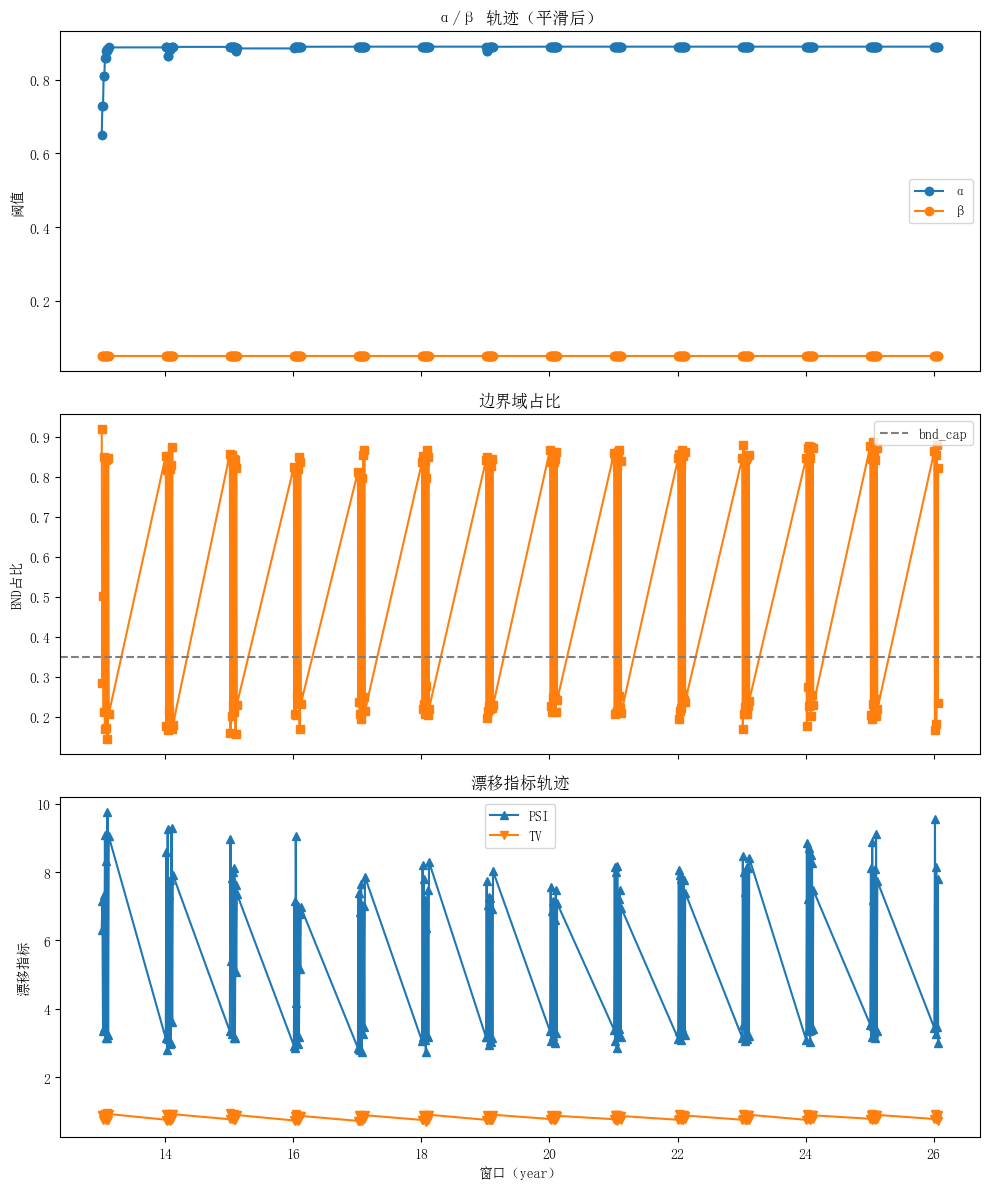

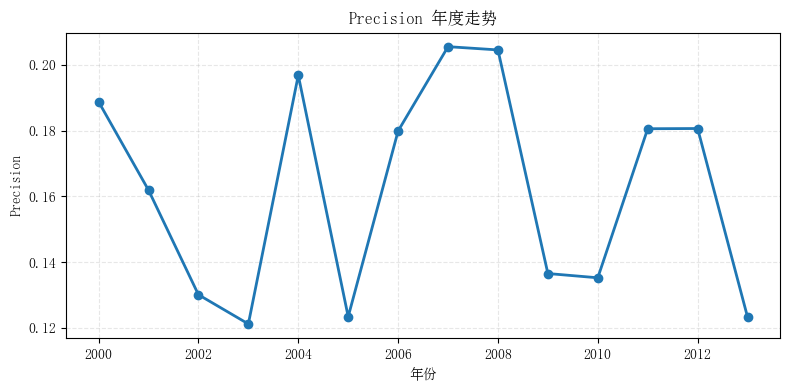

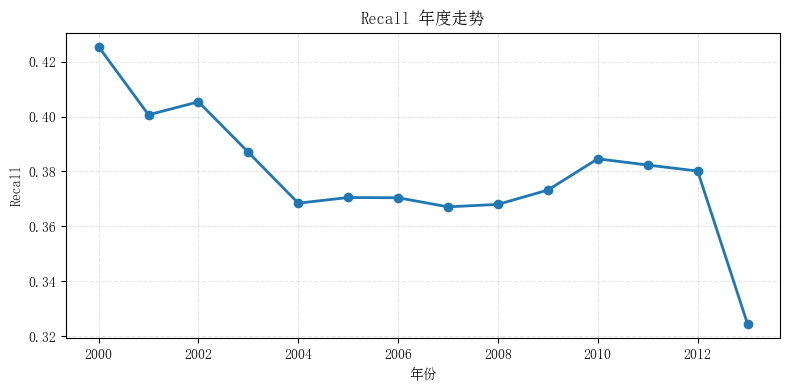

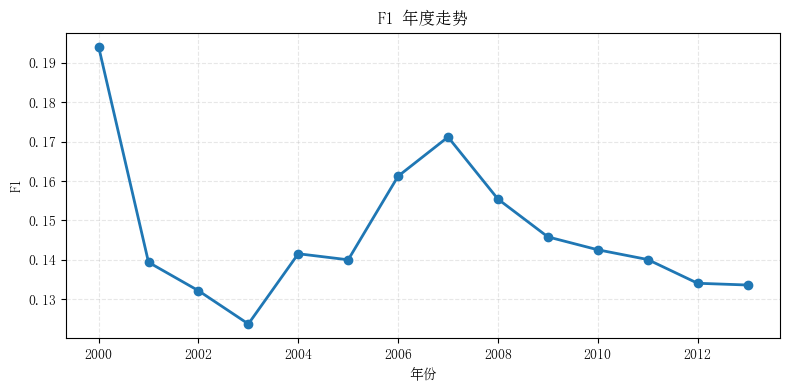

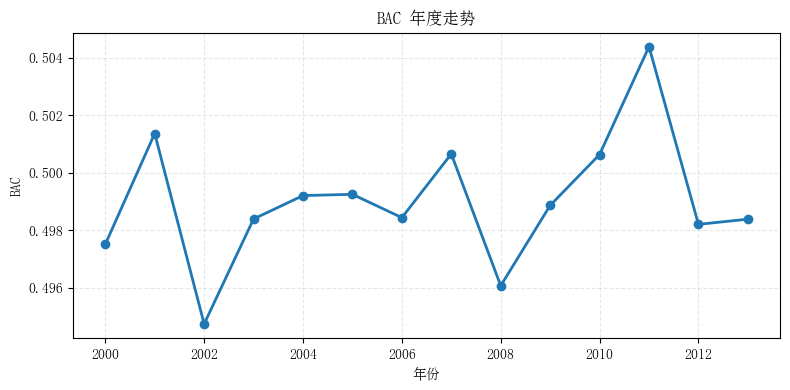

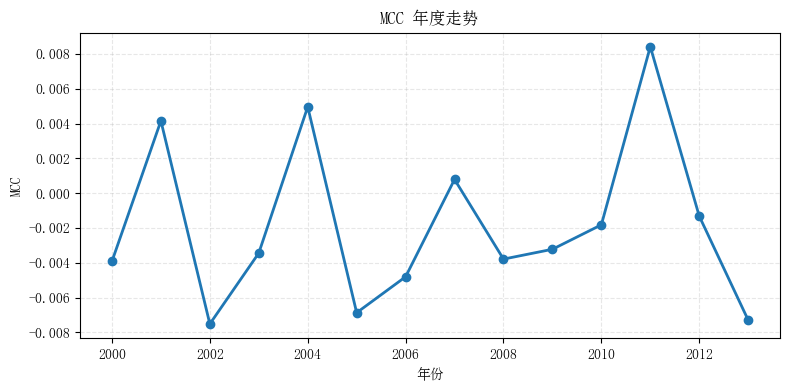

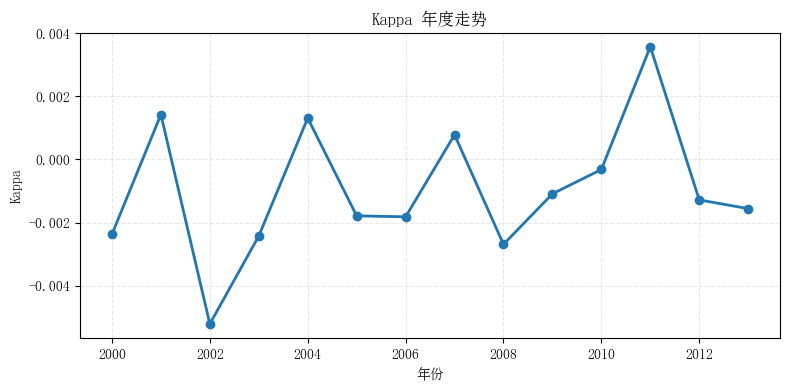

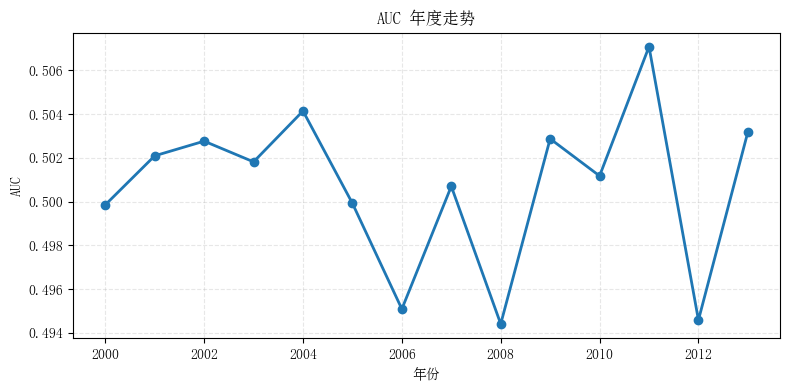

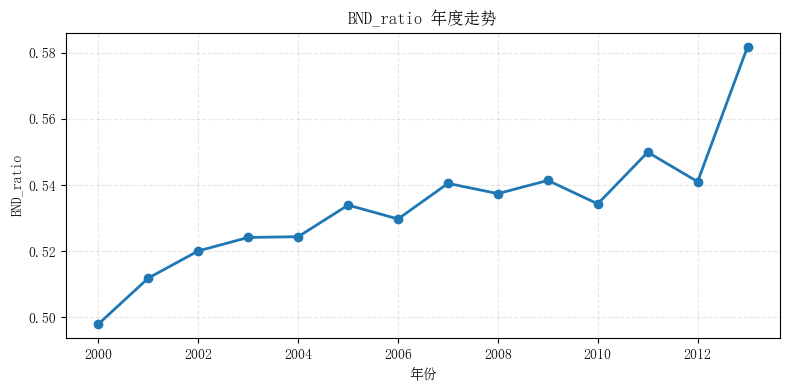

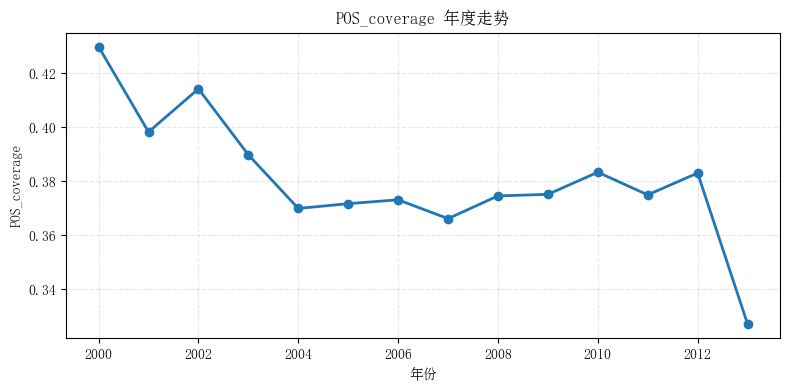

In [4]:
# 汇总阈值轨迹 / 漂移事件，并输出可视化与年度指标
trace_df = flow_threshold_df.copy() if 'flow_threshold_df' in globals() else pd.DataFrame(threshold_trace)
metrics_df = flow_metrics_df.copy() if 'flow_metrics_df' in globals() else pd.DataFrame(window_metrics)
drift_df = flow_drift_df.copy() if 'flow_drift_df' in globals() else pd.DataFrame(drift_events)
metrics_by_year_df = None
if 'yearly_metrics' in globals():
    metrics_by_year_df = yearly_metrics.copy()
elif 'metrics_by_year' in globals():
    metrics_by_year_df = metrics_by_year.copy()
else:
    metrics_by_year_df = pd.DataFrame()

output_dir = Path(cfg['DATA']['data_dir']).resolve()
output_dir.mkdir(parents=True, exist_ok=True)

trace_path = output_dir / 'threshold_trace_v02.csv'
metrics_path = output_dir / 'window_metrics.csv'
drift_path = output_dir / 'drift_events.csv'
year_metrics_path = output_dir / 'yearly_metrics.csv'

if not trace_df.empty:
    trace_df.to_csv(trace_path, index=False)
    print(f'【导出】阈值轨迹已保存到 {trace_path}')
if not metrics_df.empty:
    metrics_df.to_csv(metrics_path, index=False)
    print(f'【导出】窗口指标已保存到 {metrics_path}')
if not drift_df.empty:
    drift_df.to_csv(drift_path, index=False)
    print(f'【导出】漂移事件已保存到 {drift_path}')
if metrics_by_year_df is not None and not metrics_by_year_df.empty:
    if 'year' in metrics_by_year_df.columns:
        metrics_by_year_df = metrics_by_year_df.set_index('year')
    metrics_by_year_df.to_csv(year_metrics_path)
    print(f'【导出】年度指标已保存到 {year_metrics_path}')

if not trace_df.empty and not metrics_df.empty:
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    axes[0].plot(trace_df['window'], trace_df['alpha_smoothed'], label='α', marker='o')
    axes[0].plot(trace_df['window'], trace_df['beta_smoothed'], label='β', marker='o')
    axes[0].set_ylabel('阈值')
    axes[0].set_title('α/β 轨迹（平滑后）')
    axes[0].legend()

    bnd_col = 'BND_ratio' if 'BND_ratio' in metrics_df.columns else ('bnd_ratio' if 'bnd_ratio' in metrics_df.columns else None)
    if bnd_col is not None:
        axes[1].plot(metrics_df['window'], metrics_df[bnd_col], color='tab:orange', marker='s')
    bnd_cap = cfg['MEASURE'].get('constraints', {}).get('bnd_cap')
    if bnd_cap is not None:
        axes[1].axhline(bnd_cap, color='tab:gray', linestyle='--', label='bnd_cap')
    axes[1].set_ylabel('BND占比')
    axes[1].set_title('边界域占比')
    axes[1].legend()

    axes[2].plot(metrics_df['window'], metrics_df['psi'], label='PSI', marker='^')
    axes[2].plot(metrics_df['window'], metrics_df['tv'], label='TV', marker='v')
    axes[2].set_ylabel('漂移指标')
    axes[2].set_xlabel('窗口（year）')
    axes[2].set_title('漂移指标轨迹')
    axes[2].legend()

    plt.tight_layout()
    plt.show()
else:
    print('【提示】流式窗口为空，未生成阈值/漂移图表。')

if metrics_by_year_df is not None and not metrics_by_year_df.empty:
    years = metrics_by_year_df.index.astype(int)
    metric_titles = [
        ('Precision', 'Precision'),
        ('Recall', 'Recall'),
        ('F1', 'F1'),
        ('BAC', 'BAC'),
        ('MCC', 'MCC'),
        ('Kappa', 'Kappa'),
        ('AUC', 'AUC'),
        ('BND_ratio', 'BND_ratio'),
        ('POS_coverage', 'POS_coverage'),
    ]
    for column, title in metric_titles:
        if column not in metrics_by_year_df.columns:
            continue
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(years, metrics_by_year_df[column], marker='o', linewidth=2)
        ax.set_xlabel('年份')
        ax.set_ylabel(column)
        ax.set_title(f'{title} 年度走势')
        ax.grid(alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.show()
else:
    print('【提示】年度指标暂不可用。')
